# Problem Set 1 (PS1): Overlapping K-means Test Case with Synthetic Data
We introduced the [K-means clustering algorithm](docs/CHEME-5820-L1d-KMeans-Algorithm-Spring-2026.ipynb). The [K-means approach](https://en.wikipedia.org/wiki/K-means_clustering) is straightforward, but it has several limitations, such as the necessity to specify the number of clusters in advance. More significant issues arise with overlapping datasets or non-convex datasets. 

Let's explore a problem mentioned [in the MAT 180 Big Data course at UC Davis](https://www.math.ucdavis.edu/~strohmer/courses/180BigData/180coursematerial.html). Consider two circular data clouds, each of radius 1, and their centers are a distance $d$ apart. As long as $d > 2.08$, [K-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) yields the correct answer. But if $d\leq{2.08}$, [K-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) may fail. Moreover, this is the failure of [K-means](https://en.wikipedia.org/wiki/K-means_clustering) and not of Lloyd's algorithm, i.e., Lloyd's algorithm will converge, but to an incorrect answer.

> __Learning Objectives__
> 
> By the end of this activity, you will be able to:
> 
> * __Generate synthetic overlapping datasets:__ Create circular data clouds with controlled separation distances to test clustering algorithm behavior in distinct versus overlapping configurations.
> * __Apply K-means clustering to non-convex data:__ Implement K-means clustering on synthetic datasets and visualize how the algorithm partitions data when cluster centers are separated by varying distances.
> * __Evaluate clustering quality using multiple metrics:__ Compute silhouette scores and classification error rates to quantify clustering performance and identify the critical distance threshold where K-means fails.


Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [29]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

In addition to standard Julia libraries, we'll also use [the `VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl). Check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types, and data used in this material.

### Constants
Next, let's set some constants. See the comment next to the constant for a description of what it is, permissible values, etc.

In [30]:
number_label_one = 500; # number of points in cloud 1 (must be ≥ 2)
number_label_two = 500; # number of points in cloud 2 (must be ≥ 2)
total_number_of_points = (number_label_one + number_label_two);
number_of_features = 3; # features: (x,y,l), where l is a faux label; see below.
c̄₁ = (1.0, 1.0); # center for cluster 1: fixed
c̄₂ = (4.0, 1.0); # center for cluster 2: variable, we'll change this in our study
maxiter = 10000; # maximum iterations of our K-means implementation
K = 2; # number of clusters. We'll change this in our study (K > 1)
ϵ = 1e-6; # tolerance for termination. We can set this to whatever we want

# Validate the constants
@assert number_label_one ≥ 2 "Cloud 1 must have at least 2 points, got $(number_label_one)"
@assert number_label_two ≥ 2 "Cloud 2 must have at least 2 points, got $(number_label_two)"
@assert K ≥ 2 "K must be at least 2 for clustering, got $(K)"
@assert maxiter > 0 "Maximum iterations must be positive, got $(maxiter)"

Check if the distances between the centers are greater than (or less than) the critical threshold. We'll return the distance and a label for the case we are exploring. Distances are calculated [using methods exported by the `Distances.jl` package](https://github.com/JuliaStats/Distances.jl). In this case (and throughout), we [use the Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance).

In [31]:
# STUDENT TASK: Compute `distance` and `case_label`.
# Complete the missing code below
# HINT: Use Euclidean() distance metric and check if distance ≤ 2.08
# If you get stuck, see the solution notebook for the complete implementation

distance, case_label = let
    
    d = Euclidean(); # Euclidean distance measure from the Distances.jl package
    distance = d(c̄₁,c̄₂)# compute the distance between c̄₁ and c̄₂ using d(...)

    # Set case_label to "overlapping" if distance ≤ 2.08, else "distinct"
    case_label = "distinct"
    if (distance ≤ 2.08)
        case_label = "overlapping"# uncomment and complete → case_label = ...
    end

    # return the data to the calling scope
    distance, case_label    
end;

In [32]:
println("Distance: $(distance) with case_label: $(case_label)")
# STUDENT TASK: After you compute distance and case_label, print them here.
# Uncomment and run the line below after completing the previous cell
# println("Distance: $(distance) with case_label: $(case_label)")

Distance: 3.0 with case_label: distinct


Finally, let's set up the color dictionary to visualize the clustering results. The keys of the `my_color_dictionary::Dict{Int64, RGB}` dictionary are the cluster indexes, while the values are the colors mapped to that index. We have initially specified colors for up to three clusters. If you want more clusters, you'll need to specify additional colors. See [the `Colors.jl` package](https://github.com/JuliaGraphics/Colors.jl?tab=readme-ov-file) for details on how to specify (and model) colors.

In [33]:
my_color_dictionary = Dict{Int64,RGB}();
my_color_dictionary[1] = colorant"#03045e";
my_color_dictionary[2] = colorant"#e36414";
my_color_dictionary[3] = colorant"#00b4d8";

### Implementation
Before generating our synthetic dataset, we need to define helper functions for data generation and quality assessment. These functions will generate circular data clouds, create circle boundaries for visualization, and compute silhouette scores to evaluate clustering quality.

In [34]:
"""
    fixedcircle(center::Tuple{Float64,Float64}; number_of_points::Int = 100, radius::Float64 = 1.0) -> Array{Float64,2}

Generate random data points around a center point that lie on a circle.

### Arguments
- `center::Tuple{Float64, Float64}`: The center point around which the data points will be generated.
- `number_of_points::Int = 100`: The number of data points to generate.
- `radius::Float64 = 1.0`: The radius of the circle around the center point. Default value is 1.0.

### Returns
- A 2D array of data points. The first two columns are the x and y coordinates of the data points.
"""
function fixedcircle(center::Tuple{Float64,Float64}; 
    number_of_points::Int = 100, radius::Float64 = 1.0)::Array{Float64,2}

    # initialize -
    data = zeros(number_of_points, 2);
    θ = range(0, 2π, length=number_of_points);

    # generate the data -
    for i ∈ 1:number_of_points
        # generate random data points -
        data[i,1] = center[1] + radius * cos(θ[i]); # x
        data[i,2] = center[2] + radius * sin(θ[i]); # y
    end

    # return -
    return data;
end;

The `fixedcircle(...)` function generates evenly spaced points on a circle boundary for visualization purposes. We'll use this to overlay circle boundaries on our plots to show the true extent of each data cloud.

Next, let's define the data generation function:

In [35]:
"""
    generatedatacloud(center::Tuple{Float64,Float64}; number_of_points::Int = 100, radius::Float64 = 1.0, label::Int64 = 1) -> Array{Float64,2}

Generate random data points around a center point that have a label, and radius less than equal to the given radius.

### Arguments
- `center::Tuple{Float64,Float64}`: The center point around which the data points will be generated.
- `number_of_points::Int = 100`: The number of data points to generate.
- `radius::Float64 = 1.0`: The radius of the circle around the center point. Default value is 1.0.
- `label::Int64 = 1`: The label to assign to the data points. Default value is 1.

### Returns
- A 2D array of data points. The first two columns are the x and y coordinates of the data points, and the third column is the label.
"""
function generatedatacloud(center::Tuple{Float64,Float64}; 
    number_of_points::Int = 100, radius::Float64 = 1.0, label::Int64 = 1)::Array{Float64,2}

    # initialize -
    data = zeros(number_of_points, 3);

    # generate the data -
    for i ∈ 1:number_of_points
        
        θ = rand() * 2π; # random angle
        r = rand() * radius; # random radius

        # generate random data points -
        data[i,1] = center[1] + r * cos(θ); # x
        data[i,2] = center[2] + r * sin(θ); # y
        data[i,3] = label; # label
    end

    # return -
    return data;
end;

The `silhouette(...)` function computes the silhouette score for each data point based on the mathematical definition we'll encounter in Task 3. This implementation uses Euclidean distance by default and returns cohesion, separation, and silhouette values for each point.

Let's implement the silhouette function:

In [36]:
"""
    silhouette(data::Array{<:Number,2}, assignments::Array{Int,1}; d = Euclidean())

This function calculates the silhouette score for each data point in the data set. The silhouette score is a measure of how similar an object is to its own cluster (cohesion) 
compared to other clusters (separation). The silhouette score ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

### Arguments
- `data::Array{<:Number,2}`: A 2D array of data points that we will cluster. Features are along the columns, and data points are along the rows.
- `assignments::Array{Int,1}`: A 1D array of integers that tells us which cluster each data point belongs to.
- `d::MyAbstractDistanceMetric = Euclidean()`: The distance metric for the clustering algorithm. This is an optional argument and defaults to the Euclidean distance.

### Returns
- A 1D array of silhouette scores, one for each data point in the data set.
"""
function silhouette(data::Array{<:Number,2}, assignments::Array{Int,1}; d = Euclidean())::Array{Float64,2}
    
    # initialize -
    number_of_points = size(data, 1);
    K = length(unique(assignments));
    s = zeros(Float64, number_of_points);
    a = zeros(Float64, number_of_points);
    b = zeros(Float64, number_of_points);
    tmp = zeros(Float64, K);
    result = Array{Float64,2}(undef, number_of_points, 3);
    
    # calculate the silhouette -
    for i ∈ 1:number_of_points
        for k ∈ 1:K
            tmp[k] = mean([d(data[i,:], data[j,:]) for j ∈ findall(x-> x == k, assignments)]);
        end
        a[i] = tmp[assignments[i]];
        b[i] = minimum([tmp[k] for k ∈ 1:K if k ≠ assignments[i]]);
        s[i] = (b[i] - a[i]) / max(a[i], b[i]);
    end

    # package the results -
    for i ∈ 1:number_of_points
        result[i,1] = a[i]; # first column is the a value
        result[i,2] = b[i]; # second column is the b value
        result[i,3] = s[i]; # third column is the silhouette score
    end
    
    # return -
    return result;
end;

___

## Task 1: Generation of a synthetic dataset
In this task, we'll generate a synthetic dataset $\mathcal{D} = \left\{\mathbf{x}_{1},\mathbf{x}_{2},\dots,\mathbf{x}_{n}\right\}$ in which the data points are random $(x,y)$ values which are members of two circular data clouds.

> The first cloud will have center $\bar{c}_{1} = (1,1)$, while the second cloud center $\bar{c}_{2}$ will be variable (both center values are specified in the setup section of the notebook). Each cloud has a radius equal to `1`. In addition to the $(x,y)$ values, when generating each element of the data cloud, we give it a `faux` label $l$ of either $l\in\{1,2\}$. The label $l$ is for visualization and quality purposes (we'll exclude it in the clustering operations).

To generate the dataset, we'll follow this strategy:

> __Strategy__
>
> First, generate the $l = 1$ and $l=2$ datasets using the `generatedatacloud(...)` function defined above. Then randomly permute the dataset so that the $l = 1$ and $l = 2$ points are not in any particular order. Store the randomized dataset (with the `faux` label) in the $\hat{\mathcal{D}}$ `::Array{Float64,2}` variable. Each row of $\hat{\mathcal{D}}$ is a data point, while each column corresponds to a feature, i.e., the $x$, $y$, or $l$ value. 

Let's consider the dataset $\hat{\mathcal{D}}$ as the ground truth: data points with `faux` label $l=1$ belong together, and likewise, $l=2$ data points should be clustered together. Let's generate the data:

In [37]:
D̂ = let

    # initialize -
    D = Array{Float64,2}(undef, total_number_of_points, number_of_features);
    s₁ = generatedatacloud(c̄₁, number_of_points = number_label_one, label=1); # STUDENT TASK: generate label 1 data
    s₂ = generatedatacloud(c̄₂, number_of_points = number_label_two, label=2); # STUDENT TASK: generate label 2 data

    # mix s₁, s₂ together (randomly)
    tmp = vcat(s₁,s₂)
    random_perm_index_vector = randperm(total_number_of_points);
    for i ∈ eachindex(random_perm_index_vector)
        k = random_perm_index_vector[i]; # get the from col -
        for j ∈ 1:number_of_features
            D[i,j] = tmp[k,j];
        end
    end
    
    D # return
end;

In [38]:
# STUDENT TASK: After you build D̂, display it here.
# Uncomment the line below to display D̂
D̂

1000×3 Matrix{Float64}:
 4.47746   1.56029    2.0
 1.0472    1.27811    1.0
 1.4747    1.68509    1.0
 4.73043   1.08708    2.0
 4.33841   0.413091   2.0
 4.18494   1.03606    2.0
 1.06924   0.894161   1.0
 1.27485   0.585979   1.0
 4.45838   0.82744    2.0
 4.08738   0.895752   2.0
 ⋮                    
 4.03795   1.27125    2.0
 0.929282  0.0934003  1.0
 1.71846   1.01736    1.0
 3.96856   0.739522   2.0
 4.51557   0.335939   2.0
 3.72417   1.05897    2.0
 1.81643   1.55852    1.0
 1.68187   0.922972   1.0
 1.12493   0.881786   1.0

### Visualize the initial data clouds
`Unhide` the code block below to see how we plotted the initial synthetic dataset using [the `Plots.jl` package](https://github.com/JuliaPlots/Plots.jl), and mainly the [`scatter(...)` function](https://docs.juliaplots.org/stable/api/#Plots.scatter-Tuple). 

> __Summary__: Depending upon your choice of the second center tuple $\bar{c}_{2}$, you should have two clouds of data points that are `distinct` or `overlapping.` We have the black cloud of points for data with the `faux` label $l = 1$, while the gray points indicate the `faux` label $l = 2$. 
>
>As the distance between the centers decreases, the two clouds will overlap into a region containing a mixture of both labels. We expect [the K-means approach](https://en.wikipedia.org/wiki/K-means_clustering) will correctly capture distinct data clouds but fail with the overlapping case.

So what do you see?

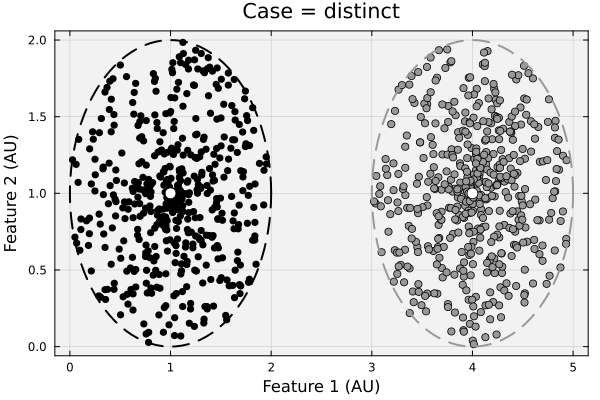

In [39]:
# STUDENT TASK: After you build D̂, uncomment the entire block below to visualize.
# (Visualization code is provided - just remove the #= and =# markers)

let

    dataset = D̂; # what dataset am I looking at?
    horizontal_index = 1;
    vertical_index = 2;
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot
    
    circle_one = fixedcircle(c̄₁);
    circle_two = fixedcircle(c̄₂);

    for i ∈ 1:total_number_of_points
        label = dataset[i,3]; # label
        c = :black;
        if label == 2
            c = :gray60
        end
        scatter!([dataset[i, horizontal_index]], [dataset[i, vertical_index]], label="", mec=:navy, c=c)
    end
    
    scatter!([c̄₁[1]], [c̄₁[2]], ms=6, mec=:black, c=:white, label="")
    scatter!([c̄₂[1]], [c̄₂[2]], ms=6, mec=:gray60, c=:white, label="")
    plot!(circle_one[:,1], circle_one[:,2], lw=2, c=:black, ls=:dash, label="")
    plot!(circle_two[:,1], circle_two[:,2], lw=2, c=:gray60, ls=:dash, label="") 
    xlabel!("Feature 1 (AU)", fontsize=18);
    ylabel!("Feature 2 (AU)", fontsize=18);
    title!("Case = $(case_label)", fontsize=18)
end


___

## Task 2: Cluster the data
In this task, we'll cluster the dataset $\mathcal{D}$ where we exclude the `faux` label, i.e., we consider only the $(x,y)$ data in the dataset. First, we'll build a `model::MyNaiveKMeansClusteringAlgorithm` instance holding information about the problem we are looking to solve; then, we'll cluster the data using [the `cluster(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/clustering/#VLDataScienceMachineLearningPackage.cluster).

Let's start by constructing the dataset $\mathcal{D}$ (no hat) from $\hat{\mathcal{D}}$ by removing the column corresponding to the `faux` label $l$:

In [40]:
# STUDENT TASK: Create D by dropping the faux label column from D̂.
# Use array slicing to select all rows but only columns 1 and 2
# HINT: D̂[:,1:end-1] selects all rows and columns 1 through second-to-last
D = D̂[:,1:end-1]; # Replace with your slicing code

Next, let's build the model instance. The `model::MyNaiveKMeansClusteringAlgorithm` contains the data that we passed in, as well as two derived fields that we computed in [the `build(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/clustering/#VLDataScienceMachineLearningPackage.build-Tuple{Type{MyNaiveKMeansClusteringAlgorithm},%20NamedTuple}), the centroids and initial assignments. 

> __Initially__:
> 
> * The `centroids::Dict{Int64, Vector{Float64}}` dictionary holds the centroid values $\mu_1, \dots, \mu_K$ for each cluster, where keys are cluster indexes and values are the `m`-dimensional centroids (means) of the data points in that cluster. 
> * The `assignments::Vector{Int64}` field is an `n`-dimensional vector holding the clustered index that each data point is assigned to. We initialize both fields based on the initial random cluster assignment.

_Fill in the missing code to build our clustering model_:

In [41]:
# STUDENT TASK: Build the K-means model with build(...).
# Complete the named tuple with the correct parameters
# HINT: dimension should be the number of features (columns) in D
# See solution notebook if you need help with the syntax

model = build(MyNaiveKMeansClusteringAlgorithm, (
        maxiter = maxiter,
        dimension = size(D,2), # replace with size(D,2)
        number_of_points = total_number_of_points,
        K = K,
        ϵ = ϵ,
        dataset = D, # replace with D
        scale_factor = 1.0,
));

#### Visualize the initial centroids and assignments
`Unhide` the code block below to see how we plotted the initial assignments and centroids. Each data point, i.e., feature vector (shown by the circles), is initially assigned to a random cluster, and the centroids dictionary is initialized based on the initial cluster assignment, where the centroids are shown as `+.`

> __Summary__: Depending upon the case, i.e., the value of $\bar{c}_{2}$, there will be two distinct (but randomly mixed up) clusters or a single (ish) cloud with mixed up values. The initial cluster centroids will be somewhere between the clouds for the `distinct` case and buried inside the cloud for the `overlapping` case. This is where [the K-means method](https://en.wikipedia.org/wiki/K-means_clustering) starts, i.e., its initial belief about how the data should be partitioned.

Let's visualize the initial state:

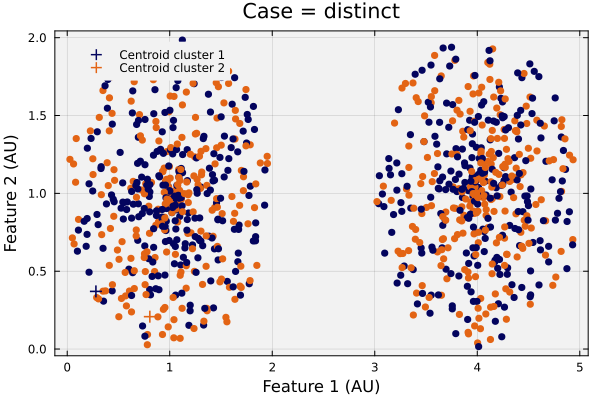

In [42]:
# STUDENT TASK: After you build `model`, uncomment the block below.
# (Visualization code is provided - just remove the #= and =# markers)
let

    dataset = D; # what dataset am I looking at?
    horizontal_index = 1;
    vertical_index = 2;
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot
   
    assignments = copy(model.assignments);
    for i ∈ eachindex(assignments);
        a = assignments[i];        
        scatter!([dataset[i, horizontal_index]], [dataset[i, vertical_index]], label="", c=my_color_dictionary[a], msc=my_color_dictionary[a]);
    end
    current();

    # plot the centroids -
    centroids = copy(model.centroids);
    for k ∈ 1:K
        c = centroids[k]
        scatter!([c[horizontal_index]], [c[vertical_index]], label="Centroid cluster $(k)", msc=my_color_dictionary[k], c=my_color_dictionary[k], 
            ms=6, markerstrokewidth=2, markershape = :plus)
    end
    current();

    xlabel!("Feature 1 (AU)", fontsize=18);
    ylabel!("Feature 2 (AU)", fontsize=18);
    title!("Case = $(case_label)", fontsize=18)
end

### Clustering
We'll call [the `cluster(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/clustering/#VLDataScienceMachineLearningPackage.cluster) to refine our initial random cluster assignments and centroid values. 

> __What's going on?__ 
>
> The method takes the data matrix `D::Array{<:Number,2}` which we want to cluster and the `model::MyNaiveKMeansClusteringAlgorithm` instance that we built above. Optional arguments include `verbose::Bool` to save data from each iteration (default `false`) and `d::Any` to specify the distance metric (default Euclidean distance from the `Distances.jl` package). 
>
> The method returns cluster centroids, the assignments, and the number of iterations in a `results::NamedTuple`.

Let's cluster the data:

In [43]:
# STUDENT TASK: Cluster the data and store the result.
# Call cluster(...) with D, model, and optional arguments
# HINT: Set verbose = true to save intermediate results
# HINT: Use tmpdir = _PATH_TO_TMP to specify where to save (folder must exist)
result = cluster(D, model, verbose = true, tmpdir = _PATH_TO_TMP); # Replace with cluster(D, model, verbose = true, tmpdir = _PATH_TO_TMP)

#### Visualize clustering results

`Unhide` the code block below to see how we plotted the cluster results. In addition, we've overlayed the data centers and the radius lines to see how the clustered data looks compared with the clustered data. 

> __What do we expect to see?__
>
> * In the `distinct` case with two clusters, [K-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) will produce clusters corresponding to a single `faux` label, i.e., the cluster will have either all orange or all blue elements that are contained in the radius one circle. 
> * In the `overlapping` case, there is a boundary between clusters that may have mixed data points. Note that because of the randomness of the initial assignment, sometimes cluster 2 (orange) will be on the left, and cluster 1 (blue) will be on the right, or vice-versa.

Let's visualize the clustering results:

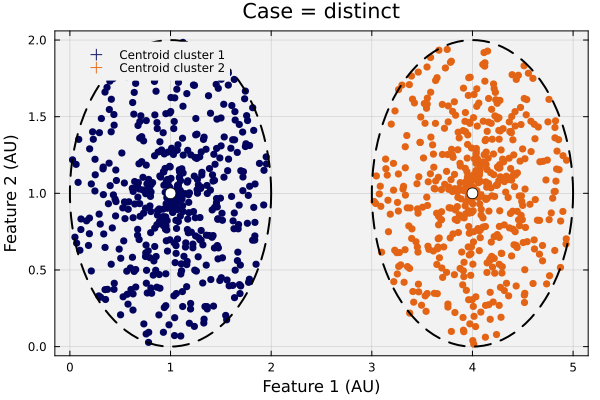

In [44]:
# STUDENT TASK: After you run clustering, uncomment the block below. 
# (Visualization code is provided - just remove the #= and =# markers)
let

    dataset = D;
    horizontal_index = 1;
    vertical_index = 2;
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot
    
    assignments = result.assignments;
    for i ∈ eachindex(assignments);
        a = assignments[i];        
        scatter!([dataset[i, horizontal_index]], [dataset[i, vertical_index]], label="", c=my_color_dictionary[a], msc=my_color_dictionary[a]);
    end
    current();

    # plot the centroids -
    centroids = result.centroids;
    for k ∈ 1:K
        c = centroids[k]
        scatter!([c[horizontal_index]], [c[vertical_index]], label="Centroid cluster $(k)", msc=my_color_dictionary[k], c=my_color_dictionary[k], 
            ms=10, markerstrokewidth=2, markershape = :plus)
    end
    current();

    circle_one = fixedcircle(c̄₁);
    circle_two = fixedcircle(c̄₂);
    plot!(circle_one[:,1], circle_one[:,2], lw=2, c=:black, ls=:dash, label="")
    plot!(circle_two[:,1], circle_two[:,2], lw=2, c=:black, ls=:dash, label="") 
    scatter!([c̄₁[1]], [c̄₁[2]], ms=6, mec=:black, c=:white, label="")
    scatter!([c̄₂[1]], [c̄₂[2]], ms=6, mec=:black, c=:white, label="")

    xlabel!("Feature 1 (AU)", fontsize=18);
    ylabel!("Feature 2 (AU)", fontsize=18);
    title!("Case = $(case_label)", fontsize=18)
end

___

## Task 3: Analyzing the quality of the clusters
In this task, we'll explore the _quality_ of the clusters as a function of different parameters. The quality (correctness) of clusters can be computed [in various ways](https://juliastats.org/Clustering.jl/stable/validate.html). 

> Here, we'll consider two methods to assess the quality of the clusters obtained from [the K-means clustering algorithm](docs/CHEME-5820-L1d-KMeans-Algorithm-Spring-2026.ipynb):
>
> * __Method 1__ uses [the silhouette score](docs/CHEME-5820-L1d-KMeans-Algorithm-Spring-2026.ipynb), which measures how similar an object is to its cluster (cohesion) compared to other clusters (separation), ranging from -1 to 1 where higher values indicate better matching. 
>* __Method 2__ computes the error rate by comparing cluster assignments to the `faux` labels to determine the fraction of incorrectly clustered points, similar to the [binary classification problem](https://en.wikipedia.org/wiki/Binary_classification) where feature vectors predict datapoint type.

After we implement these two assessment methods, you'll answer some discussion questions about what this assessment data is telling us.

#### Method 1: Silhouette score
Assume that we have clustered the data into $K$ clusters.
Let $C(\mathbf{x}_i)$ denote the cluster that contains data point $\mathbf{x}_i$, and let $d(\mathbf{x}_i, \mathbf{x}_j) = \|\mathbf{x}_i - \mathbf{x}_j\|_{2}$ denote the Euclidean distance between data points $\mathbf{x}_i$ and $\mathbf{x}_j$.
Then, for a data point $\mathbf{x}_i\in C(\mathbf{x}_i)$, let $a(i)$ denote the average distance between $\mathbf{x}_i$ and all other points in the __same cluster__:
$$
\begin{equation*}
a(i) = \frac{1}{|C(\mathbf{x}_i)| - 1}\sum_{\mathbf{x}_m \in C(\mathbf{x}_i),\; m \ne i}d(\mathbf{x}_i,\mathbf{x}_m)
\end{equation*}
$$
The term $|C(\mathbf{x}_i)|$ denotes the number of data points in the cluster containing $\mathbf{x}_i$.
Thus, $a(i)$ measures the compactness (cohesion) of the cluster. 

Next, we define $b(i)$ to be the smallest mean distance of data point $\mathbf{x}_{i}$ to all points in any other cluster in which point $i$ is not a member. The cluster with this smallest mean dissimilarity is said to be the _neighboring cluster_ of data point $i$ because it is the next best-fit cluster for data point $i$:
$$
\begin{equation*}
b(i) = \min_{C \in \mathcal{C},\; C \ne C(\mathbf{x}_i)} \; \frac{1}{|C|} \sum_{\mathbf{x}_m \in C} d(\mathbf{x}_i, \mathbf{x}_m)
\end{equation*}
$$
Putting it all together, the silhouette score $s(i)$ for data point $\mathbf{x}_i$ is defined as:
$$
\begin{equation*}
s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}\quad\text{if}\,|C(\mathbf{x}_i)|>1
\end{equation*}
$$
If $|C(\mathbf{x}_i)|=1$, then $s(i)=0$. This gives a silhouette score for each data point as:
$$
\begin{equation*}
   s(i) =
   \begin{cases}
      1 - a(i)/b(i) & \text{if } a(i) < b(i)\\ 
      0 & \text{if } a(i) = b(i)\\
      b(i)/a(i) - 1 & \text{if } a(i) > b(i)
   \end{cases}
\end{equation*}
$$
This definition shows $-1\leq s(i)\leq 1$. 
The mean $s(i)$ of all data points in a cluster measures how tightly grouped the points in the cluster are. 
We've implemented the computation of the silhouette score in the `silhouette(...)` function defined above. _Call the `silhouette(...)` function to compute the silhouette score_:

In [45]:
# STUDENT TASK: Compute silhouette scores and the mean s̄.
# Complete the code below to compute silhouette scores
# HINT: The silhouette function returns a 3-column array: [a, b, s]
# HINT: Use mean(...) to compute the average of column 3
s̄, silhouette_result_array  = let
    
    # Get the cluster assignments from the result
    a = result.assignments; # Replace with result.assignments
    
    # Call silhouette function (returns array with columns: a, b, s)
    silhouette_result_array = silhouette(D, a); # Replace with silhouette(D, a)
    
    # Compute the average silhouette score (column 3)
    s̄ = mean(silhouette_result_array[:,3]); # Replace with mean(silhouette_result_array[:,3])
    
    s̄, silhouette_result_array # return data to the caller
end;

In [46]:
# STUDENT TASK: After computing s̄, print it here.
# Uncomment the line below
println("The overall mean silhouette score for distance = $(distance) is: $(s̄)")

The overall mean silhouette score for distance = 3.0 is: 0.749781264401948


#### Method 2: Classification error rate
This method quantifies how many times a point was placed in the correct cluster. Consider the binary case, i.e., $K = 2$. Because K-means labels can swap left/right, set `blue_is_left::Bool` based on the plot (blue = cluster 1, orange = cluster 2).

Set the cluster orientation:

In [47]:
blue_is_left = false; # set true if the blue (cluster 1) cloud is leftmost, false if rightmost

The code block below computes the fraction of points that are _misclassified_ after mapping the K-means cluster labels to the `faux` labels. Set `blue_is_left` to indicate whether the blue (cluster 1) cloud is leftmost; if it is rightmost, the assignments are flipped before computing `error_fraction::Float64`. If $K \ne 2$, a [@info statement is generated](https://docs.julialang.org/en/v1/stdlib/Logging/#Logging.@logmsg).

Let's compute the error fraction:

In [48]:
# STUDENT TASK: Compute error_fraction for K == 2.
# Complete the missing logic to compute classification errors
# HINT: Compare mapped_label with the faux label D̂[i,3]
# HINT: Count mismatches and divide by total_number_of_points

error_fraction = let

    error_fraction = nothing;
    if (K == 2)

        errors = 0.0;
        a = result.assignments;
        for i ∈ 1:total_number_of_points
            mapped_label = a[i];
            if (blue_is_left == false)
                mapped_label = (mapped_label == 1) ? 2 : 1;
            end

            # TODO: Add 1.0 to errors if mapped_label doesn't match D̂[i,3]
            # HINT: Use ternary operator → (condition) ? value_if_true : value_if_false
            errors += (mapped_label == D̂[i,3]) ? 0.0 : 1.0; # TODO: Complete this line
        end
        error_fraction = (errors)/total_number_of_points;    
    else
        @info "Alternative assessment method 2 not applicable."
    end
    error_fraction # return
end;

In [49]:
# STUDENT TASK: After computing error_fraction, display it here.
# Uncomment the line below
error_fraction

1.0

### Discussion questions (DQs)
Run the notebook for $\bar{c}_{2} = (10.0,1.0)$ (`distinct` case) and $\bar{c}_{2} = (2.0,1.0)$ (`overlapping` case), and answer the following questions.

__DQ1:__ Are the silhouette scores directly or indirectly proportional to the distance between the data cloud clusters? Why might you expect this relationship based on the definition, and what do you expect as the distance between cluster centers grows?

> **To answer this question, consider:**
> 
> - **(a)** Run the notebook with $\bar{c}_{2} = (10.0, 1.0)$ (distinct case). What is the mean silhouette score $\bar{s}$?
> - **(b)** Run the notebook with $\bar{c}_{2} = (2.0, 1.0)$ (overlapping case). What is the mean silhouette score $\bar{s}$ now?
> - **(c)** Based on parts (a) and (b), what pattern do you observe? Does $\bar{s}$ increase or decrease as the distance between cluster centers decreases?
> - **(d)** Looking at the silhouette score definition, why does this relationship make sense? Think about what happens to $b(i)$ (separation) as clusters move farther apart.
> - **(e)** Prediction: What would you expect to happen to $\bar{s}$ as the distance between centers approaches infinity?

In [50]:
# Put your answer to DQ1 (either as a commented code cell, or as a markdown cell)

In [51]:
# STUDENT TASK: Set to true after you answer DQ1.
did_I_answer_DQ1 = true; # update to true if answered DQ1 {true | false}

__DQ2__: In situations where _Method 2_ is applicable, does this alternative assessment criteria support what the silhouette scores are saying? Could you explain why _Method 2_ supports or refutes the silhouette scores? As the cluster centers become close, what error rate do you expect?

> **To answer this question, consider:**
> 
> - **(a)** For the distinct case ($\bar{c}_{2} = (10.0, 1.0)$), what is the `error_fraction`? Make sure to set `blue_is_left` correctly based on your visualization.
> - **(b)** For the overlapping case ($\bar{c}_{2} = (2.0, 1.0)$), what is the `error_fraction`?
> - **(c)** Compare the trends: When silhouette scores are high, is the error fraction low? When silhouette scores are low, is the error fraction high?
> - **(d)** Do both methods agree that the distinct case has better clustering quality than the overlapping case? Explain.
> - **(e)** As the cluster centers get closer and closer (distance → 2.08 and below), what do you predict will happen to the error rate? Would it approach 0%, 50%, or 100%? Why?
> - **(f)** Why is Method 2 only applicable when $K = 2$? What information would you need to use this method for $K > 2$?

In [52]:
# Put your answer for DQ2 here (either as a commented code cell, or as a markdown cell)

In [53]:
# STUDENT TASK: Set to true after you answer DQ2.
did_I_answer_DQ2 = false; # update to true if answered DQ2 {true | false}

__DQ3__: For the `overlapping` case, explain what happens when you increase the number of clusters to $K = 3$?

> **To answer this question:**
> 
> - **(a)** Set $\bar{c}_{2} = (2.0, 1.0)$ and $K = 3$, then re-run the entire notebook. What do you observe in the final clustering visualization? Where is the third cluster located?
> - **(b)** What is the mean silhouette score $\bar{s}$ with $K = 3$? Compare it to the $\bar{s}$ you got with $K = 2$ for the same overlapping case.
> - **(c)** Did increasing $K$ to 3 improve or worsen the clustering quality according to the silhouette score? Why or why not?
> - **(d)** Looking at the visualization, do you see 3 natural groups in the data, or are you forcing K-means to find 3 clusters when there are really only 2?
> - **(e)** What does this tell you about the importance of choosing the right value of $K$? What might happen if you set $K$ too high for your data?
> - **(f)** Try $K = 4$ or $K = 5$. What pattern do you observe as $K$ increases beyond the true number of clusters?

In [54]:
# Put your answer for DQ3 here (either as a commented code cell, or as a markdown cell)

In [55]:
# STUDENT TASK: Set to true after you answer DQ3.
did_I_answer_DQ3 = false; # update to true if answered DQ3 {true | false}

___

## Summary
K-means clustering successfully partitions distinct data clouds but fails predictably when circular clusters of radius 1 overlap beyond a critical distance threshold of 2.08 between centers.

> __Key Takeaways:__
> 
> * **Synthetic data reveals algorithmic limitations:** Generating controlled circular data clouds with variable center separation allows systematic testing of K-means behavior, demonstrating that the algorithm fails when center distance falls below the 2.08 threshold.
> * **Multiple quality metrics provide complementary insights:** Silhouette scores measure cluster cohesion and separation, while classification error rates (comparing against known labels) quantify misclassification frequency, with both metrics declining as clusters overlap.
> * **Lloyd's algorithm converges to incorrect solutions:** When data clouds overlap significantly, the K-means implementation converges successfully but produces incorrect cluster assignments, illustrating that convergence does not guarantee correctness.

This example demonstrates a fundamental limitation of K-means clustering and motivates the need for alternative clustering methods when data exhibits non-convex or overlapping structures.
___

## Tests
In the code block below, we check some values in your notebook and give you feedback on which items are correct or different. `Unhide` the code block below (if you are curious) about how we implemented the tests and what we are testing.

In [56]:
let 
    @testset verbose = true "CHEME 5820 problem set 1 test suite" begin
        
        @testset "Setup, Prerequisites and Data" begin
            @test _DID_INCLUDE_FILE_GET_CALLED == true
            @test number_label_one ≥ 2
            @test number_label_two ≥ 2
            @test K ≥ 2
        end

        @testset "Task 1: Generation of a synthetic dataset" begin
            number_of_rows = size(D̂,1);
            number_of_cols = size(D̂,2);
            @test total_number_of_points == number_of_rows
            @test number_of_cols == 3
        end

        @testset "Task 2: Cluster the data" begin
            @test isnothing(D) == false
            @test isnothing(model) == false
            @test isnothing(result) == false
        end

        @testset "Task 3: Analyzing the quality of the clusters" begin
            @test isa(s̄, Number) == true
            @test did_I_answer_DQ1 == true
            @test did_I_answer_DQ2 == true
            @test did_I_answer_DQ3 == true
        end
    end
end;

Task 3: Analyzing the quality of the clusters: Test Failed at /Users/wangzhengxiang/Documents/GitHub/ps1-5820-s26-ChengHsiangWangShawn/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y110sZmlsZQ==.jl:27
  Expression: did_I_answer_DQ2 == true
   Evaluated: false == true

Stacktrace:
 [1] top-level scope
   @ ~/Documents/GitHub/ps1-5820-s26-ChengHsiangWangShawn/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y110sZmlsZQ==.jl:4
 [2] macro expansion
   @ ~/.julia/juliaup/julia-1.12.4+0.aarch64.apple.darwin14/share/julia/stdlib/v1.12/Test/src/Test.jl:1776 [inlined]
 [3] macro expansion
   @ ~/Documents/GitHub/ps1-5820-s26-ChengHsiangWangShawn/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y110sZmlsZQ==.jl:25 [inlined]
 [4] macro expansion
   @ ~/.julia/juliaup/julia-1.12.4+0.aarch64.apple.darwin14/share/julia/stdlib/v1.12/Test/src/Test.jl:1776 [inlined]
 [5] macro expansion
   @ ~/Documents/GitHub/ps1-5820-s26-ChengHsiangWangShawn/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y11

Test.TestSetException: Some tests did not pass: 11 passed, 2 failed, 0 errored, 0 broken.